In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import matplotlib as mpl
from typing import Tuple, Dict
%matplotlib inline
# %matplotlib notebook
import seaborn as sns

font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] =2
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, to_rgb
from matplotlib.ticker import MultipleLocator


def register_tintmap(name: str, hex_color: str):
    c = to_rgb('#'+hex_color) if not hex_color.startswith('#') else to_rgb(hex_color)
    cmap = LinearSegmentedColormap.from_list(name, [(1,1,1), c, (0.05,0.05,0.05)], N=256)
    mpl.colormaps.register(cmap, name=name)
    return name

OI_BLUE    = register_tintmap("OI_BLUE",    "#0072B2")
OI_ORANGE  = register_tintmap("OI_ORANGE",  "#E69F00")
OI_MAGENTA = register_tintmap("OI_MAGENTA", "#CC79A7")
OI_Vermillion = register_tintmap("OI_Vermillion", "#D55E00")
OI_Bluish_Green = register_tintmap("OI_Bluish_Green", "#009E73")
to_plot = ['GREEDY', 'UCB', 'TS', 'AGENT','SIMPLEAGENT', 'GPT5','Qwen3']


ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")
N_SAMPLES=10



In [2]:
#!python tabulate_results.py --results-dir ../results/96_384_simulations --output data/96_384_simulations.csv

In [3]:
from dataclasses import dataclass
from typing import Dict, Iterable
import hashlib
import matplotlib as mpl

@dataclass(frozen=True)
class ClassStyle:
    cmap: str
    base: float = 0.22
    span: float = 0.6
    quantize: int = 4
    jitter: float = 0.05
    
class AcqStyler:
    """
    Colors per acquisition (class-coherent), and dashes per acquisition (vary within class).
    """
    # IMPORTANT: seaborn expects dash *sequences* like (5,3), not (offset, (5,3))
    _DASH_BANK = [
        (),                 # solid
        (5, 3),             # dashed
        (3, 2, 1.5, 2),     # dashdot
        (10, 3),             # long-dash
        (8, 2, 1.2, 2),     # long-dash dot
        (2, 2, 2, 4)       # dot-dot-dash
    ]

    def __init__(self, class_styles: Dict[str, ClassStyle] | None = None):
        self.class_quant = {"statistical": 5, "agent": 3, "llm": 3, "finetuned": 3, "baseline": 2}
        default = {
            "statistical": ClassStyle(cmap="OI_MAGENTA", quantize=self.class_quant["statistical"]),
            "agent":       ClassStyle(cmap="OI_Bluish_Green", quantize=self.class_quant["agent"]),
            "llm":         ClassStyle(cmap="OI_BLUE", quantize=self.class_quant["llm"]),
            "finetuned":   ClassStyle(cmap="OI_Vermillion", quantize=self.class_quant["finetuned"]),
            "baseline":    ClassStyle(cmap="Greys"),  # color ignored; baseline -> black
        }
        self.class_idx = {"statistical" : 0, "agent": 1, "llm":2, "finetuned":3, "baseline":4}
        self.class_styles = default if class_styles is None else class_styles
        self.acq_to_class: Dict[str, str] = {}
        self.acq_to_idx: Dict[str, int] = {}  
        self.class_counts = {"statistical": 0, "agent": 0, "llm": 0, "finetuned": 0, "baseline": 0}

    def register(self, name: str, klass: str):
        cls = klass.lower()
        self.acq_to_class[name] = cls
        if cls not in self.class_counts:
            self.class_counts[cls] = 0
        # assign next available index
        self.acq_to_idx[name] = self.class_counts[cls]
        self.class_counts[cls] += 1

    def color(self, name: str):
        if name.lower() in {"random", "baseline"} or self.acq_to_class.get(name) == "baseline":
            return "black"
        cls = self._lookup_class(name)
        cs = self.class_styles[cls]
        idx = (self.acq_to_idx.get(name, 0) + self.class_idx[cls]) % self.class_quant[cls]
        cmap = mpl.colormaps.get(cs.cmap)

        Q = max(1, cs.quantize)
        bin_size = cs.span / Q
        bin_idx = idx % Q  # wrap if more items than bins
        center = cs.base + (bin_idx + 0.5) * bin_size
        return cmap(min(0.98, max(0.02, center)))

    def register_many(self, mapping: Dict[str, str]):
        for k, v in mapping.items():
            self.register(k, v)

    def palette(self, levels: Iterable[str]) -> Dict[str, tuple]:
        return {a: self.color(a) for a in levels}

    def line_style(self) -> Dict[str, object]:
        return {"lw":2.5}
        
    def dashes_for(self, levels: Iterable[str], unique_within_class: bool = True) -> Dict[str, tuple]:
        levels = list(levels)
        L = len(self._DASH_BANK)
        lvl_class = {a: self._lookup_class(a) for a in levels}

        dashes: Dict[str, tuple] = {}

        # --- force baselines ---
        for a in levels:
            if lvl_class[a] == "baseline":
                dashes[a] = (1, 1)   # dotted
            #if a == 'UCB':
            #    dashes[a] = (10, 3)           # extra-long dash
        # ------------------------

        if not unique_within_class:
            for a in levels:
                if a not in dashes:
                    # still use hash if not enforcing uniqueness
                    dashes[a] = self._DASH_BANK[self._hash32(a) % L]
            return dashes

        # --- assign by registration order ---
        by_class: Dict[str, list[str]] = {}
        for a in levels:
            if a not in dashes:   # skip baselines
                by_class.setdefault(lvl_class[a], []).append(a)

        for cls, names in by_class.items():
            for a in names:
                idx_in_class = self.acq_to_idx.get(a, 0)
                dashes[a] = self._DASH_BANK[idx_in_class % L]

        return dashes

        
    def order_acqs(self, levels: Iterable[str],
                   class_order=("statistical", "agent", "llm","finetuned", "baseline")) -> list[str]:
        levels = list(levels)
        return sorted(levels, key=lambda a: (class_order.index(self._lookup_class(a)), a.lower()))

    def prune_class_legend(self, ax):
        handles, labels = ax.get_legend_handles_labels()
        ban = set(self.class_styles.keys()) | {"Class", "Acquisition"}
        kept = [(h, l) for h, l in zip(handles, labels) if l not in ban]
        if kept:
            ax.legend([h for h, _ in kept], [l for _, l in kept],
                      fontsize=12, frameon=False, handlelength=3.5)
        else:
            leg = ax.get_legend()
            if leg:
                leg.remove()

    def _lookup_class(self, name: str) -> str:
        if name.lower() in {"random", "baseline"}:
            return "baseline"
        return self.acq_to_class.get(name, "llm")

    @staticmethod
    def _hash32(s: str) -> int:
        return int(hashlib.sha1(s.encode("utf-8")).hexdigest()[:8], 16)

    def _sample_t(self, name: str, cs: ClassStyle) -> float:
        h = self._hash32(name)
        Q = max(3, cs.quantize)
        bin_size = cs.span / Q
        bin_idx = h % Q
        jitter_unit = ((h // Q) & 0xFFFF) / 0xFFFF
        center = cs.base + (bin_idx + 0.5) * bin_size
        t = center + (jitter_unit - 0.5) * (cs.jitter * bin_size)
        return max(0.02, min(0.98, t))

STYLER = AcqStyler()
classes = [
    ("GREEDY",       "statistical"), 
    ("TS",           "statistical"),
    ("EI",           "statistical"),
    ("$\epsilon$-GREEDY",    "statistical"),
    ("UCB",          "statistical"),
    ("Qwen3",        "llm"),
    ("GPT5",         "llm"),
    ("Deepseek",     "llm"),
    ("SIMPLEAGENT",  "agent"),
    ("AGENT",        "agent"),
    ("Random",       "baseline"),
    ("Qwen3-BLIND",  "finetuned"),
    ("GPT5-BLIND",   "finetuned"),
    ("Deepseek-BLIND", "finetuned"),
    ("Qwen2.5-SFT", "finetuned"),
    ("Qwen2.5-DPO", "finetuned"),
]
for name, klass in classes:
    STYLER.register(name, klass)

In [4]:
def plot_trajectory(ax, df, budget, batch_size, DE=0, y = 'recall05pc', legend=True, ylabel=None,xlabel=True, std=False):
    # Show legend only on top-right subplot
    df = df.copy()
    if not std:
        df = df.groupby(['Acquisition', 'Timestep']).mean().reset_index()

    df['Class'] = df['Acquisition'].map(STYLER.acq_to_class)


    order   = STYLER.order_acqs(df['Acquisition'].unique())
    palette = STYLER.palette(order)
    dashes  = STYLER.dashes_for(order)
    
    levels = [a for a in df['Acquisition'].unique()]
    order = STYLER.order_acqs(levels)
    palette = STYLER.palette(order)
    dashes = STYLER.dashes_for(order)
    ax = sns.lineplot(data=df, x="Timestep", y=y, hue='Acquisition', 
                    hue_order=order, errorbar=('pi', 100), legend=legend, style='Acquisition', palette=palette, dashes=dashes, **STYLER.line_style())
    ax.plot([0, budget + batch_size], [0, DE], color='black', linestyle='--', label='DE', **STYLER.line_style())
    if legend:
        STYLER.prune_class_legend(ax) 

    plt.xticks(np.arange(0, budget + batch_size+1, batch_size))
    if ylabel:
        plt.ylabel(ylabel)
    else:
        plt.ylabel('')
    plt.xlabel('# Variants')
    
    # Top row: remove x-axis labels and add titles
    if not xlabel: 
        ax.set_xticklabels([])
        ax.set(xlabel=None)
    return ax
        
def plot_bar(ax, df, title, budget, batch_size, random_baseline = 0.21,DE_baseline = 0.44,MLDE_baseline = 0.38, legend=True, names=True, x_ticks=True, protein='GB1'):
    # Get final timestep data
    last = df[df['Timestep'] == budget + batch_size].copy()
    # Show legend only on top-right subplot
    last = last[last['Acquisition'] != 'Random']
    last['Class'] = last['Acquisition'].map(STYLER.acq_to_class)
    order   = STYLER.order_acqs(last['Acquisition'].unique())
    palette = STYLER.palette(order)
    ax = sns.barplot(data=last, x='Mean', y='Acquisition', hue='Acquisition',
                    order=order, hue_order=order, errorbar=('pi', 100), legend=False, orient='h', palette=palette, capsize=0.1)

    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.ylabel(protein)
    reference_lines = []
    reference_labels = []

    line1 = ax.axvline(x=DE_baseline, color='black', linestyle='--', **STYLER.line_style())  # DE single step greedy walk result
    #line2 = ax.axvline(x=MLDE_baseline, color='black', linestyle=':')  # MLDE...?
    reference_lines.extend([line1])
    reference_labels.extend(['DE'])
    reference_lines.append(ax.axvline(x=random_baseline, color='k', linestyle=':', **STYLER.line_style()))
    reference_labels.append('Random')
    
    plt.xlabel('Max Fitness Achieved')
    if legend:
        all_handles = reference_lines
        all_labels = reference_labels
        ax.legend(all_handles, all_labels, fontsize=12)
    # Add labels inside bars with conditional naming
    if names:
        shown = [o for o in order if o in last.Acquisition.unique()]
        for bar, label in zip(ax.patches, shown):
            h = bar.get_height()
            ax.text(0.02, bar.get_y() + h/2, label, ha='left', va='center',
                    fontsize=10, color='white', weight='bold')

    ax.set_yticklabels([])
    plt.title(title)

    # X-axis label handling for Figure 2 (adjusted for horizontal orientation)
    if not x_ticks:
        # Left column: remove x-axis labels
        ax.set_xticklabels([])
        ax.set(xlabel=None)
    else:
        # Right column: move x-axis labels to top
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")
    return ax


In [5]:
def reset_batch_max(df, batch_size, budget):
    for protein in df['Protein'].unique():
        for acq in df['Acquisition'].unique():
            for encoding in df['Encoding'].unique():
                maxval = 0
                maxstd = 0
                mask = (df['Protein'] == protein) & (df['Acquisition'] == acq) & (df['Encoding'] == encoding)
                for i in range(0, budget+batch_size +1, batch_size):
                    range_df = df[(df['Timestep'] > i) & (df['Timestep'] <= i+batch_size) & mask]
                    maxval = max(range_df['Mean']) if len(range_df) > 0 else 0  
                    maxstd = range_df[range_df['Mean'] == maxval]['Std'].iloc[0] if len(range_df) > 0 else 0    
                    df.loc[range_df.index, 'Mean'] = maxval
                    df.loc[range_df.index, 'Std'] = maxstd
                #df.loc[(df['Timestep'] >= budget+batch_size//2) & mask, 'Mean'] = maxval
                #df.loc[(df['Timestep'] >= budget+batch_size//2) & mask, 'Std'] = maxstd
    return df

In [6]:
def apply_steps_se(df_in: pd.DataFrame, batch_size=10, se=True) -> pd.DataFrame:
    df = df_in.copy()
    df = df.loc[(df['Timestep'] % batch_size == 0) | (df['Timestep'] == 1),:].reset_index(drop=True)
    n = pd.Series(10, index=df.index)
    n[df['Acquisition'].isin(['GREEDY', 'UCB', 'TS'])] = 50
    n = n.astype(float)
    t = pd.Series(stats.t.ppf(0.975, n - 1), index=df.index)
    f = lambda x: x / n.pow(0.5) * t if se else  x
    df_lower = df.copy()
    df_upper = df.copy()
    delta05 = f(df['recall05pc_std'])
    delta2  = f(df['recall2pc_std'])
    deltastd = f(df['Std'])
    df_lower['Mean'] = df['Mean'] - deltastd
    df_upper['Mean'] = df['Mean'] + deltastd
    df_lower['recall05pc'] = df['recall05pc'] - delta05
    df_upper['recall05pc'] = df['recall05pc'] + delta05
    df_lower['recall2pc']  = df['recall2pc']  - delta2
    df_upper['recall2pc']  = df['recall2pc']  + delta2
    df_lower[['recall05pc','recall2pc','Mean']] = df_lower[['recall05pc','recall2pc','Mean']].clip(0, 1)
    df_upper[['recall05pc','recall2pc','Mean']] = df_upper[['recall05pc','recall2pc','Mean']].clip(0, 1)

    return pd.concat([df_lower, df_upper], ignore_index=True)

# Analyzing Computational Simulations on GB1 and TrpB


### Analyzing Optimization Trajectories
For looking at the effect of different models, encodings, and acquisition functions

In [7]:
se = False

In [8]:
batch_size = 10
budget = 50
dfstandalone = pd.read_csv('data/10_50_standalone4.csv')
dfblind = pd.read_csv('data/10_50_standaloneBLIND.csv')
gpt5 = pd.read_csv('data/10_50_standaloneOpenai-new.csv')
deepseek = pd.read_csv('data/10_50_standaloneDeepseek.csv')

gpt5blind = pd.read_csv('data/10_50_openaiBLIND.csv')
gpt5['Acquisition'] = gpt5['Acquisition'].replace('AGENT', 'GPT5')
deepseek['Acquisition'] = "Deepseek"
deepseekblind = pd.read_csv('data/10_50_standaloneDeepseekBLIND.csv')
gpt5blind['Acquisition'] = gpt5blind['Acquisition'].replace('AGENT', 'GPT5-BLIND')
deepseekblind['Acquisition'] = 'Deepseek-BLIND'
deepseekblind['Model'] = 'DNN Ensemble'
dfsimple = pd.read_csv('data/10_50_simpleagentUCB.csv')
dfstandalone.fillna(0, inplace=True)
dfblind.fillna(0, inplace=True)
dfagents = pd.read_csv('data/10_50_agents.csv')
dfagent = dfagents[dfagents['Acquisition'] == 'AGENT']
dfblind = dfblind[dfblind['Acquisition'] == 'AGENT']
dfblind['Model'] = 'DNN Ensemble'
dfblind['Acquisition'] = 'Qwen3-BLIND'
dfstandalone['Acquisition'] = dfstandalone['Acquisition'].replace('AGENT', 'STANDALONE')
dfstandalone['Encoding'] = dfstandalone['Encoding'].replace('AA', 'onehot')
dfstandalone = dfstandalone[dfstandalone['Acquisition'] == 'STANDALONE']
dfstandalone['Acquisition'] = 'Qwen3'
while len(dfblind) < budget+batch_size:
    last = dfblind.iloc[-1].copy()
    last['Timestep'] = last['Timestep'] + 1
    dfblind.loc[len(dfblind)] = last

name_map = {"MegaScience-7B": "MegaScience-SFT", "Qwen2-0_5B-DPO":"Qwen2.5-DPO", "Qwen2-7B-Instruct":"Qwen2-7B", "Qwen2-7B-SFT":"Qwen2.5-SFT"}
files = ["Qwen2-0_5B-DPO-0728_2", "Qwen2-7B-Instruct", "Qwen2-7B-SFT-0731", "MegaScience-7B-0731"]
batch_size = 10
budget = 50
dfs_sft = []
for file in files:
    path = f'data/10_50_{file}.csv'
    name = [name_map[key] for key in name_map if key in file][0]
    print(name)
    df = pd.read_csv(path)
    df['Model'] = name
    df['Acquisition'] = name
    df['Encoding'] = 'onehot'
    while len(df) < budget+batch_size:
        last = df.iloc[-1].copy()
        last['Timestep'] = last['Timestep'] + 1
        df.loc[len(df)] = last
    dfs_sft.append(df)
print(dfstandalone.columns)

Qwen2.5-DPO
Qwen2-7B
Qwen2.5-SFT
MegaScience-SFT
Index(['Protein', 'Encoding', 'Model', 'Acquisition', 'Timestep', 'Mean',
       'Std', 'recall2pc', 'recall2pc_std', 'recall05pc', 'recall05pc_std',
       'accuracy2pc', 'accuracy2pc_std', 'accuracy05pc', 'accuracy05pc_std'],
      dtype='object')


In [9]:
statsdf = pd.read_csv('data/10_50_stats.csv')
statsdf['Acquisition'] = statsdf['Acquisition'].replace('RBF', '$\epsilon$-GREEDY')
dfs = [dfblind, dfagent, dfsimple, dfstandalone, deepseekblind, gpt5, gpt5blind, deepseek, statsdf] + dfs_sft

dfshort = apply_steps_se(pd.concat(dfs), se=se)
dfshort.loc[dfshort['Model'] == 'Random','Acquisition'] = 'Random'
dfshort['Acquisition'].unique()

array(['Qwen3-BLIND', 'AGENT', 'SIMPLEAGENT', 'Random', 'Qwen3',
       'Deepseek-BLIND', 'GPT5', 'GPT5-BLIND', 'Deepseek', 'EI',
       '$\\epsilon$-GREEDY', 'GREEDY', 'TS', 'UCB', 'Qwen2.5-DPO',
       'Qwen2-7B', 'Qwen2.5-SFT', 'MegaScience-SFT'], dtype=object)

In [10]:
statsdf[ (statsdf['Encoding'] == 'onehot') & (statsdf['Model'] == 'DNN Ensemble')].groupby(['Acquisition','Protein']).max()

Encoding         Model  Timestep      Mean  \
Acquisition       Protein                                              
$\epsilon$-GREEDY GB1       onehot  DNN Ensemble        60  0.607661   
                  TrpB      onehot  DNN Ensemble        60  0.490175   
EI                GB1       onehot  DNN Ensemble        60  0.526590   
                  TrpB      onehot  DNN Ensemble        60  0.462565   
GREEDY            GB1       onehot  DNN Ensemble        60  0.630359   
                  TrpB      onehot  DNN Ensemble        60  0.509467   
TS                GB1       onehot  DNN Ensemble        60  0.615370   
                  TrpB      onehot  DNN Ensemble        60  0.523107   
UCB               GB1       onehot  DNN Ensemble        60  0.562591   
                  TrpB      onehot  DNN Ensemble        60  0.496555   

                                Std  recall2pc  recall2pc_std  recall05pc  \
Acquisition       Protein                                                   
$\epsilon$-GREEDY GB1      0.029694   0.006171       0.002447    0.011352   
                  TrpB     0.044552   0.004367       0.003946    0.008518   
EI                GB1      0.028963   0.004552       0.002256    0.007470   
                  TrpB     0.041998   0.003299       0.003057    0.005779   
GREEDY            GB1      0.030334   0.006546       0.002117    0.012450   
                  TrpB     0.045044   0.004599       0.004046    0.009447   
TS                GB1      0.031215   0.006325       0.002462    0.012129   
                  TrpB     0.043335   0.004511       0.003657    0.008869   
UCB               GB1      0.029177   0.005114       0.002333    0.009130   
                  TrpB     0.041890   0.003889       0.003209    0.006910   

                           recall05pc_std  accuracy2pc  accuracy2pc_std  \
Acquisition       Protein                                                 
$\epsilon$-GREEDY GB1            0.007834     0.307333         0.140000   
                  TrpB           0.009615     0.231667         0.271293   
EI                GB1            0.006602     0.226667         0.140000   
                  TrpB           0.006733     0.175000         0.271293   
GREEDY            GB1            0.006843     0.326000         0.140000   
                  TrpB           0.010142     0.244000         0.271293   
TS                GB1            0.007697     0.315000         0.140000   
                  TrpB           0.009250     0.239333         0.271293   
UCB               GB1            0.006562     0.254667         0.140000   
                  TrpB           0.007425     0.206333         0.271293   

                           accuracy05pc  accuracy05pc_std  
Acquisition       Protein                                  
$\epsilon$-GREEDY GB1          0.141333          0.097539  
                  TrpB         0.113000          0.127553  
EI                GB1          0.093000          0.084902  
                  TrpB         0.076667          0.089629  
GREEDY            GB1          0.155000          0.089579  
                  TrpB         0.125333          0.135101  
TS                GB1          0.151000          0.095941  
                  TrpB         0.117667          0.123357  
UCB               GB1          0.113667          0.085799  
                  TrpB         0.091667          0.098503

In [11]:
stats_long = pd.read_csv('data/96_384_stats.csv')
stats_long['Acquisition'] = stats_long['Acquisition'].replace('RBF', '$\epsilon$-GREEDY')
simpleagent_long = pd.read_csv('data/96_384_simpleagentUCB-new.csv')
agent_long = pd.read_csv('data/96_384_agents.csv')
gpt5_long = pd.read_csv('data/96_384_standaloneOpenai.csv')
qwen3_long = pd.read_csv('data/96_384_standaloneQwen.csv')
gpt5_long['Acquisition'] = gpt5_long['Acquisition'].replace('AGENT', 'GPT5')
qwen3_long['Acquisition'] = qwen3_long['Acquisition'].replace('AGENT', 'Qwen3')
df_sft_96 = pd.read_csv('data/96_384_Qwen2-7B-SFT-0731.csv')
df_sft_96['Acquisition'] = 'Qwen2.5-SFT'
df_sft_96['Model'] = 'Qwen2.5-SFT'
df_sft_96 = df_sft_96[df_sft_96['Timestep'] <= 480]
#agent = reset_batch_max(agent, 96, 384)
dflong = apply_steps_se(pd.concat([stats_long, simpleagent_long, agent_long,gpt5_long, qwen3_long, df_sft_96]), se=se, batch_size=96)
dflong.loc[dflong['Model'] == 'Random','Acquisition'] = 'Random'
print(dflong.Acquisition.unique())

['EI' '$\\epsilon$-GREEDY' 'GREEDY' 'TS' 'UCB' 'Random' 'SIMPLEAGENT'
 'AGENT' 'GPT5' 'Qwen3' 'Qwen2.5-SFT']


### Add in the single round results?

In [12]:
def plot_all(to_plot, y='recall05pc'):
    plt.figure(1, figsize=(12, 10))
    assert sum([x in STYLER.acq_to_class.keys() for x in to_plot]) == len(to_plot)
    model_encoding_combos = [
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 60, Target: GB1\n Model: Onehot-DNN', 'protein': 'GB1', 'short': True},  # Left column
        {'model': 'GP', 'encoding': 'ESM2', 'title': 'Budget: 60, Target: GB1\n Model: ESM2-GP', 'protein': 'GB1', 'short': True},         # Right column
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 480, Target: GB1\n Model: Onehot-DNN', 'protein': 'GB1', 'short': False},  # Left column
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 60, Target: TrpB\n Model: Onehot-DNN', 'protein': 'TrpB', 'short': True},         # Right column
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 480, Target: TrpB\n Model: Onehot-DNN', 'protein': 'TrpB', 'short': False},  # Left column
    ]

    i = 0
    axs1 = []
    axs2 = []

    for i, combo in enumerate(model_encoding_combos):
        if combo['short']:
            budget = 50
            batch_size = 10
            df2 = dfshort.copy()
        else:
            budget = 384
            batch_size = 96
            df2 = dflong.copy()    
        # Filter data for specific protein, model, and encoding
        df2['Encoding'] = df2['Encoding'].replace('Random', combo['encoding'])
        df2 = df2.loc[df2['Acquisition'].isin(to_plot),:]
        for acq in ['Qwen3-BLIND', 'GPT5-BLIND', 'GPT5','Qwen3', 'Deepseek-BLIND','Qwen2.5-SFT','MegaScience-SFT','Qwen2.5-DPO','Qwen2-7B', 'Deepseek']:
            df2.loc[df2['Acquisition'] == acq,'Encoding'] = combo['encoding']
            df2.loc[df2['Acquisition'] == acq,'Model'] = combo['model']
        subset = df2[
            (df2['Protein'] == combo['protein']) & 
            (df2['Model'] == combo['model']) & 
            (df2['Encoding'] == combo['encoding'])
        ]
        # Figure 1: Line plots showing AL campaign development
        fig, ax = plt.subplots(1,1,figsize=(6,5))
        params = {
            'ax': ax,
            'df': subset,
            'budget': budget,
            'batch_size': batch_size,
            'y': y,
            'ylabel': 'Recall@0.5%',
            'xlabel': True,
            'std': False,
            'DE': [{'recall05pc':0.003125, 'recall2pc':0.003901}, {'recall05pc':0.005858, 'recall2pc':0.0061}, {'recall05pc':0.0926, 'recall2pc':0.0614}, 
                {'recall05pc':0.003125, 'recall2pc':0.003901},{'recall05pc':0.131689, 'recall2pc':0.059829}][i]['recall05pc']
        }
        ax = plot_trajectory(**params)
        plt.title(combo['title'])
        axs1.append(ax)
        i += 1
    plt.figure(1)
    plt.tight_layout()
    # plt.savefig('acquisition_trajectories.svg')
    plt.show()
    model_encoding_combos = [
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 60, Model: Onehot-DNN', 'protein': 'GB1', 'short': True},  # Left column
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 480, Model: Onehot-DNN', 'protein': 'GB1', 'short': False},  # Left column
        {'model': 'GP', 'encoding': 'ESM2', 'title': 'Budget: 60, Model: ESM2-GP', 'protein': 'GB1', 'short': True},         # Right column
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 60, Model: Onehot-DNN', 'protein': 'TrpB', 'short': True},         # Right column
        {'model': 'DNN Ensemble', 'encoding': 'onehot', 'title': 'Budget: 480, Model: Onehot-DNN', 'protein': 'TrpB', 'short': False},         # Right column
    ]
    i = 0
    for combo in model_encoding_combos:
        if combo['short']:
            budget = 50
            batch_size = 10
            df2 = dfshort.copy()
        else:
            budget = 384
            batch_size = 96
            df2 = dflong.copy()
        
        # Filter data for specific protein, model, and encoding
        df2['Encoding'] = df2['Encoding'].replace('Random', combo['encoding'])
        df2 = df2.loc[df2['Acquisition'].isin(to_plot),:]
        for acq in ['Qwen3-BLIND', 'GPT5-BLIND', 'GPT5','Qwen3', 'Deepseek-BLIND','Qwen2.5-SFT','MegaScience-SFT','Qwen2.5-DPO','Qwen2-7B', 'Deepseek']:
            df2.loc[df2['Acquisition'] == acq,'Encoding'] = combo['encoding']
            df2.loc[df2['Acquisition'] == acq,'Model'] = combo['model']
        subset = df2[
            (df2['Protein'] == combo['protein']) & 
            (df2['Model'] == combo['model']) & 
            (df2['Encoding'] == combo['encoding'])
        ]
        print(f"{combo['protein']}, {combo['model']}, {combo['encoding']}: {len(subset)} rows")
        print(f"Available acquisitions: {subset['Acquisition'].unique()}")
        print(f"Timestep range: {subset['Timestep'].min()} to {subset['Timestep'].max()}")
        # Figure 2: Bar plots showing final fitness
        plt.figure(2)
        if True: #i % 2 == 0:
            fig,ax = plt.subplots(1,1,figsize=(6,5))
        else:
            fig,ax = plt.subplots(1,1,figsize=(12,10),sharey=axs2[-1])
        random_subset = df2[
            (df2['Protein'] == combo['protein']) & 
            (df2['Model'] == 'Random') & 
            (df2['Timestep'] == budget+batch_size)
        ]
        if not random_subset.empty:
            final_random = random_subset['Mean'].mean()
        else:
            final_random = 0.21
        params = {
            'ax': ax,
            'df': subset,
            'budget': budget,
            'batch_size': batch_size,
            'random_baseline': final_random,
            'DE_baseline': 0.44,
            'MLDE_baseline': 0.38,
            'legend': True,
            'names': True,
            'x_ticks': True,
            'title': combo['title'],
            'protein': combo['protein'],
        }
        if False: #i != 0:
            params['legend'] = False
        if False: #i > 1:
            params['x_ticks'] = False
        if combo['short'] and not combo['protein'] == 'TrpB':
            ax.set_xlim([0, 0.8])
            ax = plot_bar(**params)
        elif combo['protein'] == 'TrpB':
            ax.set_xlim([0, 1])
            params['DE_baseline'] = 0.63
            ax = plot_bar(**params)
        else:
            ax.set_xlim([0, 1])
            params['DE_baseline'] = 0.66
            params['MLDE_baseline'] = 0.73
            ax = plot_bar(**params)
        axs2.append(ax)
        i += 1
        plt.show()

    plt.figure(2)
    plt.tight_layout()
    # plt.savefig('acquisition_final_fitness.svg')

/tmp/ipykernel_1393828/157255903.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['Acquisition', 'Timestep']).mean().reset_index()


/tmp/ipykernel_1393828/157255903.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['Acquisition', 'Timestep']).mean().reset_index()
/tmp/ipykernel_1393828/157255903.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['Acquisition', 'Timestep']).mean().reset_index()
/tmp/ipykernel_1393828/157255903.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['Acquisition', 'T

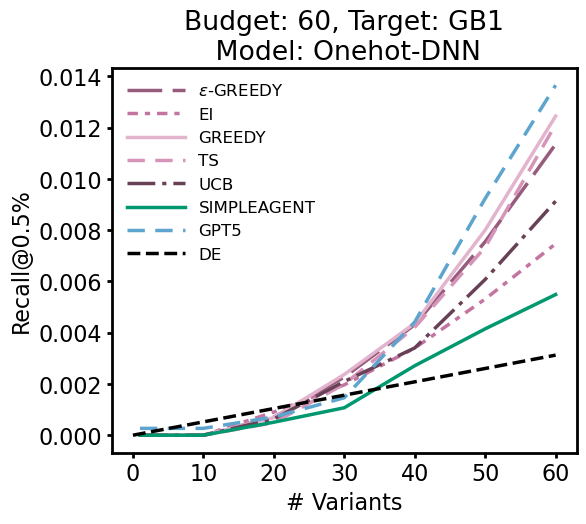

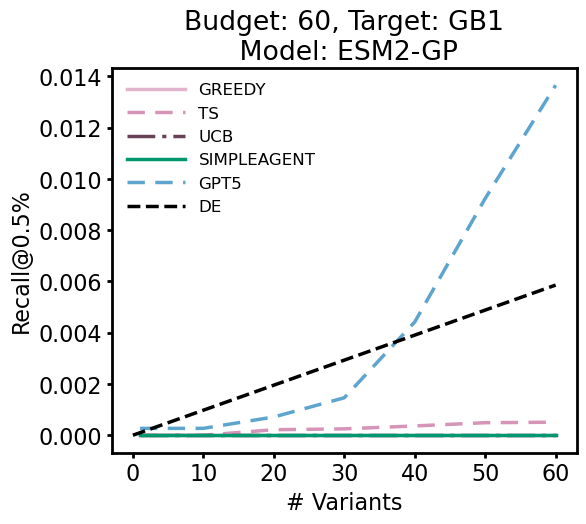

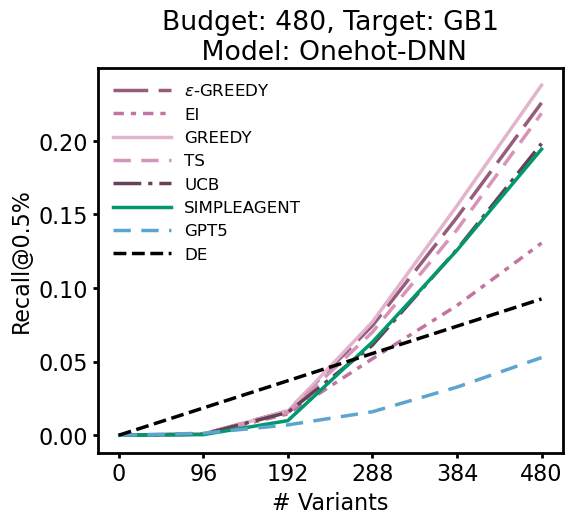

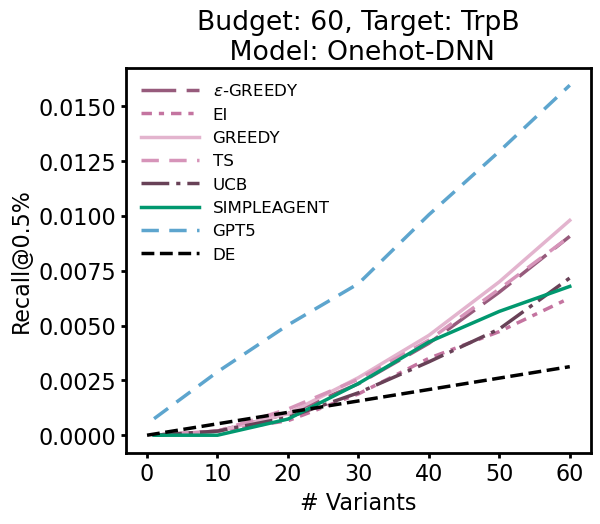

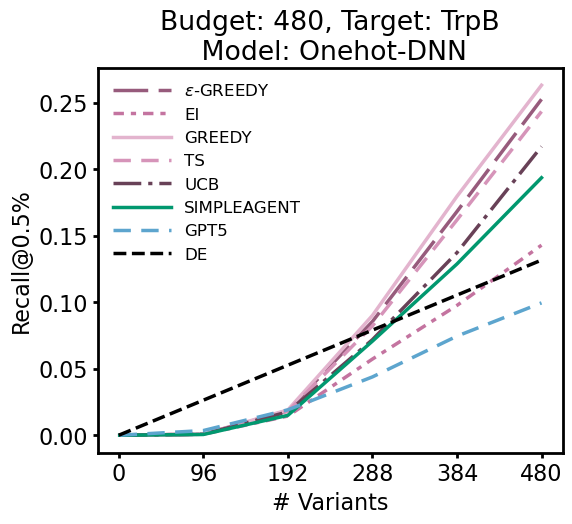

<Figure size 1200x1000 with 0 Axes>

GB1, DNN Ensemble, onehot: 98 rows
Available acquisitions: ['SIMPLEAGENT' 'GPT5' 'EI' '$\\epsilon$-GREEDY' 'GREEDY' 'TS' 'UCB']
Timestep range: 1 to 60


<Figure size 640x480 with 0 Axes>

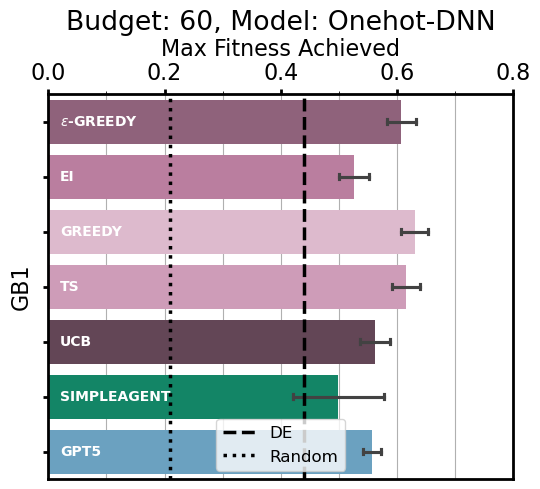

GB1, DNN Ensemble, onehot: 96 rows
Available acquisitions: ['EI' '$\\epsilon$-GREEDY' 'GREEDY' 'TS' 'UCB' 'SIMPLEAGENT' 'GPT5']
Timestep range: 1 to 480


<Figure size 640x480 with 0 Axes>

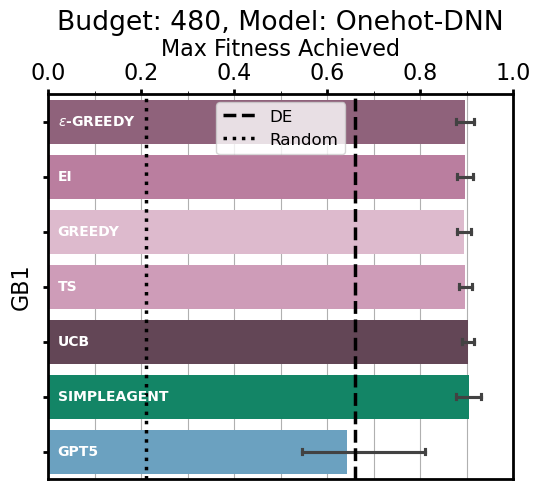

GB1, GP, ESM2: 70 rows
Available acquisitions: ['SIMPLEAGENT' 'GPT5' 'GREEDY' 'TS' 'UCB']
Timestep range: 1 to 60


<Figure size 640x480 with 0 Axes>

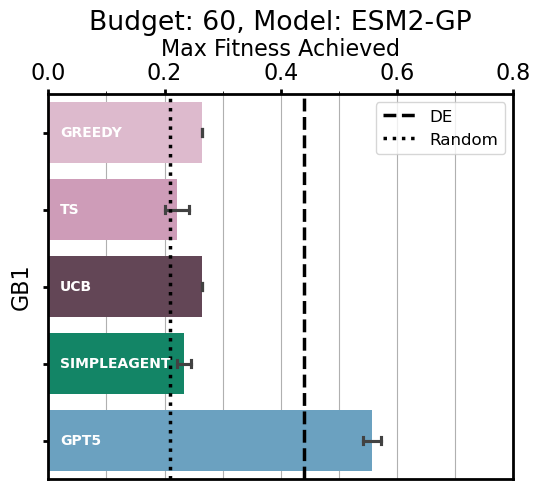

TrpB, DNN Ensemble, onehot: 98 rows
Available acquisitions: ['SIMPLEAGENT' 'GPT5' 'EI' '$\\epsilon$-GREEDY' 'GREEDY' 'TS' 'UCB']
Timestep range: 1 to 60


<Figure size 640x480 with 0 Axes>

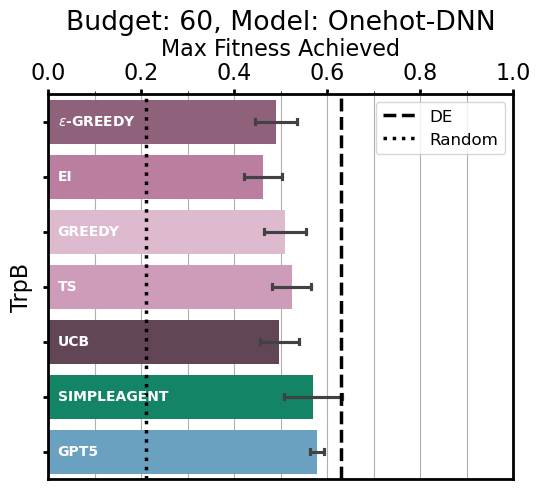

TrpB, DNN Ensemble, onehot: 96 rows
Available acquisitions: ['EI' '$\\epsilon$-GREEDY' 'GREEDY' 'TS' 'UCB' 'SIMPLEAGENT' 'GPT5']
Timestep range: 1 to 480


<Figure size 640x480 with 0 Axes>

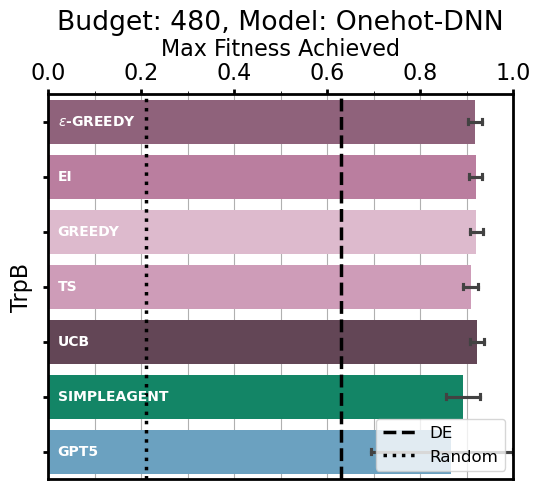

<Figure size 640x480 with 0 Axes>

In [13]:
alt_1 = ['UCB', 'Deepseek','Qwen3', 'GPT5', 'Deepseek-BLIND', 'Qwen3-BLIND', 'GPT5-BLIND', 'Random']
alt_2 = ['UCB', 'Qwen3', 'GPT5', 'Qwen2.5-SFT', 'Qwen2.5-DPO'] 
alt_3 = ['GREEDY', 'UCB', 'Qwen3', 'GPT5', 'Deepseek', 'SIMPLEAGENT', 'AGENT'] # 
alt_4 = ['GREEDY', 'UCB', 'TS', 'EI', '$\epsilon$-GREEDY','GPT5','SIMPLEAGENT']
plot_all(alt_4, 'recall05pc')
# Plot all the alt_1, alt_2, alt_3

Convergence 

In [14]:
short = pd.read_csv('data/60_onehot_conv.csv')
short_esm2 = short[short['Model'] == 'GP']
short = short[short['Model'] == 'DNN Ensemble']
long = pd.read_csv('data/384_onehot_conv.csv')
simpleshort = pd.read_csv('data/50_blosum_conv.csv')
simpleshort['Acquisition'] = 'SIMPLEAGENT'

simplelong = pd.read_csv('data/384_blosum_conv.csv')
short = short[short['Protein'] == 'GB1']
long = pd.concat([long, simplelong]) 
dfs = [short,long]
for d in dfs:
    d.loc[d['Model'] == 'Random','Acquisition'] = 'Random'


Index(['Protein', 'Encoding', 'Model', 'Acquisition', 'n_samples', 'Mean',
       'Std', 'recall2pc', 'recall2pc_std', 'recall05pc', 'recall05pc_std'],
      dtype='object')
['TS' 'GREEDY' 'UCB']
['TS' 'GREEDY' 'UCB']
['TS' 'GREEDY' 'Random' 'UCB' 'SIMPLEAGENT']
['TS' 'GREEDY' 'Random' 'UCB' 'SIMPLEAGENT']


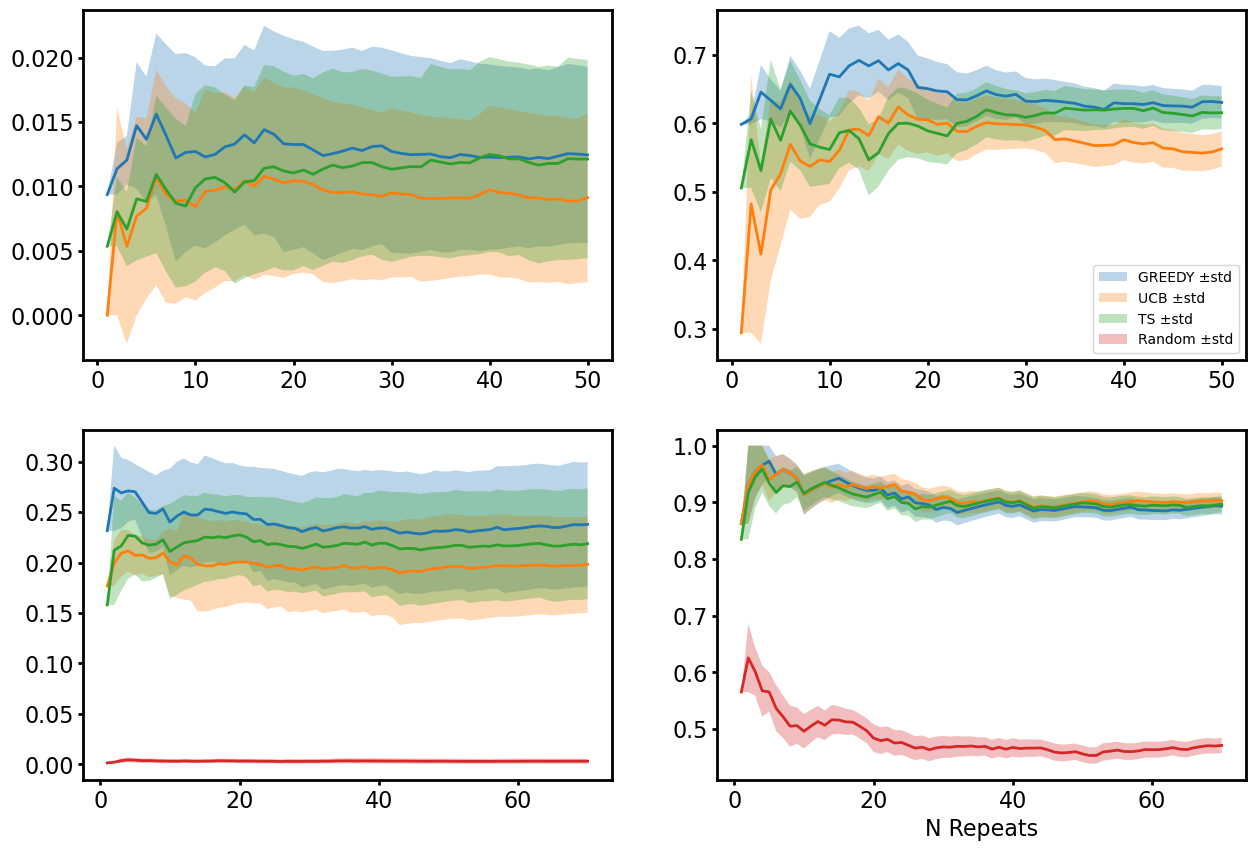

In [15]:
fig, axs = plt.subplots(2,2, figsize=(15, 10))
acq_order = ['GREEDY', 'UCB', 'TS','Random']
print(dfs[0].columns)
for i in range(4):
    ax = axs[i//2, i%2]
    subencode = dfs[i // 2]
    target = 'recall05pc' if i % 2 == 0 else 'Mean'
    std = 'recall05pc_std' if i % 2 == 0 else 'Std'
    print(subencode['Acquisition'].unique())
    for acq in acq_order: 
        subset = subencode[(subencode['Acquisition'] == acq)]
        ax.fill_between(subset['n_samples'], subset[target] - subset[std], subset[target] + subset[std], alpha=0.3, label=f'{acq} ±std')
        ax.plot(subset['n_samples'], subset[target], linewidth=2)
    if i == 1:
        ax.legend(fontsize=10)
#axs[1,1].plot([15,15],[0,1], color='black', linestyle='--')
axs[1,1].set_xlabel('N Repeats')
plt.show()

# Bootstrapping

In [ ]:
order = ['GREEDY', 'UCB', 'TS','EI', '$\epsilon$-GREEDY', 'AGENT','SIMPLEAGENT', 'Deepseek','GPT5','Qwen3','SFT', 'Deepseek-BLIND', 'Qwen3-BLIND', 'GPT5-BLIND']
stat_aq = ['GREEDY', 'UCB', 'TS','EI', '$\epsilon$-GREEDY']
files = {'10_50_simpleagentUCB': ['SIMPLEAGENT'], '10_50_standalone4':['Qwen3'], 
        '10_50_standaloneBLIND': ['Qwen3-BLIND'], '10_50_standaloneOpenai': ['GPT5'], 
        '10_50_standaloneOpenai_BLIND': ['GPT5-BLIND'], '10_50_standaloneDeepseek':['Deepseek'],
        '10_50_simulation' : ['GREEDY', 'UCB', 'TS', 'EI', 'RBF'], '96_384_simulations' : ['GREEDY', 'UCB', 'TS', 'EI', 'RBF'],
        '96_384_simpleagentUCB-new' : ['SIMPLEAGENT'],
        '96_384_standaloneQwen':['Qwen3'], '96_384_standaloneOpenai':['GPT5'], '10_50_agents':['AGENT'], 
        '96_384_agents':['AGENT'], '10_50_standaloneDeepseekBLIND':['Deepseek-BLIND'], 
        '10_50_Qwen2-7B-SFT-0731':['SFT'], '96_384_Qwen-7B-SFT-Long-0731':['SFT']
}
gb1_fitness = pd.read_csv("../data/GB1/fitness.csv")
trpB_fitness = pd.read_csv("../data/TrpB/fitness.csv")
fitness_dfs = {"GB1": gb1_fitness, "TrpB": trpB_fitness}
import glob
import torch
from scipy import stats

In [18]:
gb1_fitness = pd.read_csv("../data/GB1/fitness.csv")
trpB_fitness = pd.read_csv("../data/TrpB/fitness.csv")
gb1_fitness['fitness'] = (gb1_fitness['fitness'] - gb1_fitness['fitness'].min()) / (gb1_fitness['fitness'].max() - gb1_fitness['fitness'].min())
trpB_fitness['fitness'] = (trpB_fitness['fitness'] - trpB_fitness['fitness'].min()) / (trpB_fitness['fitness'].max() - trpB_fitness['fitness'].min())
fitness_dfs = {"GB1": gb1_fitness, "TrpB": trpB_fitness}
def read_data(filenm, fn, budget, protein):
    path = f'../results/{filenm}/{protein}/onehot/*indices.pt'
    fitness = fitness_dfs[protein]['fitness'].values
    cut_off = np.quantile(fitness, 0.995)
    files = glob.glob(path)
    if len(files) == 0:
        print(f"No files found for {filenm} {protein}")
        return None
    pts = []
    fitness_values = []
    seeds = []
    for file in files:
        if "Random" not in file and (fn not in stat_aq or f'-{fn}-' in file):
            seed = int(file.split('/')[-1].split('_')[-1][:-len('indices.pt')])
            if fn in stat_aq and seed > 50:
                continue
            indices = torch.load(file)
            indices = np.asarray(indices, dtype=int)

            if indices.shape[0] > budget:
                print(f"Truncating {file} to {budget} points")
                indices = indices[:budget]
            elif indices.shape[0] < budget:
                print(f"Padding {file} with {budget - indices.shape[0]} points")
                indices = np.pad(indices, (0, budget - indices.shape[0]), mode='constant', constant_values=indices[-1])
            pts.append(indices)
            seeds.append(seed)
    # stack into a 2D array (num_files × budget)
    pts = np.vstack(pts)
    # vectorized indexing
    fitness_values = fitness[pts]
    maxs = np.max(fitness_values, axis=1)
    recalls = np.sum(fitness_values > cut_off, axis=1) / (len(fitness)*0.005)
    df = pd.DataFrame({
        'seed': seeds,
        'max': maxs,
        'recall': recalls,
    })
    df['Acquisition'] = fn
    df['budget'] = budget
    df['Protein'] = protein
    return df

def get_all_scores():
    dfs = []
    for filenm, fns in files.items():
        budget = 60 if '10' in filenm else 480
        for protein in ['GB1', 'TrpB']:
            for fn in fns:
                dfs.append(read_data(filenm, fn, budget, protein))
    return pd.concat(dfs)

In [19]:
all_scores_data = get_all_scores()

/tmp/ipykernel_1393828/4061366337.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  indices = torch.load(file)
/tmp/ipykernel_1393828/4061366337.py:22: FutureWarning: You

Truncating ../results/10_50_simpleagentUCB/GB1/onehot/DNN_ENSEMBLE-DO-0-RBF-SIMPLEAGENT-[30, 1]_7indices.pt to 60 points


/tmp/ipykernel_1393828/4061366337.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  indices = torch.load(file)
/tmp/ipykernel_1393828/4061366337.py:22: FutureWarning: You

Padding ../results/96_384_standaloneQwen/GB1/onehot/AGENT_LLM-DO-0-RBF-AGENT-[1, 1]_3047318411indices.pt with 384 points
Padding ../results/96_384_standaloneQwen/GB1/onehot/AGENT_LLM-DO-0-RBF-AGENT-[1, 1]_403154036indices.pt with 148 points
Padding ../results/96_384_standaloneQwen/TrpB/onehot/AGENT_QWEN-DO-0-RBF-AGENT-[1, 1]_2871989863indices.pt with 96 points
Padding ../results/96_384_standaloneQwen/TrpB/onehot/AGENT_QWEN-DO-0-RBF-AGENT-[1, 1]_3939496635indices.pt with 39 points


/tmp/ipykernel_1393828/4061366337.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  indices = torch.load(file)
/tmp/ipykernel_1393828/4061366337.py:22: FutureWarning: You

No files found for 96_384_Qwen2-7B-SFT-Long-0731 GB1
No files found for 96_384_Qwen2-7B-SFT-Long-0731 TrpB


In [20]:
all_scores_data['Acquisition'] = all_scores_data['Acquisition'].replace('RBF', '$\epsilon$-GREEDY')
print(all_scores_data.drop(columns=['seed']).groupby(['Protein', 'budget', 'Acquisition']).mean())
print(all_scores_data.columns)

                                       max    recall
Protein budget Acquisition                          
GB1     60     $\epsilon$-GREEDY  0.588514  0.010509
               AGENT              0.447544  0.003571
               Deepseek           0.505117  0.010311
               Deepseek-BLIND     0.552219  0.017943
               EI                 0.526591  0.007472
               GPT5               0.557106  0.013658
               GPT5-BLIND         0.596814  0.019684
               GREEDY             0.630359  0.012453
               Qwen3              0.457365  0.003214
               Qwen3-BLIND        0.411473  0.002544
               SFT                0.517262  0.007900
               SIMPLEAGENT        0.499288  0.005490
               TS                 0.615370  0.012132
               UCB                0.562591  0.009132
        480    $\epsilon$-GREEDY  0.897171  0.205400
               AGENT              0.903986  0.166041
               EI                 0.895961  0.

In [21]:
def is_significantly_different(subdf1, subdf2, n_samples=10000, 
                              metric_type='recall', threshold=0.95):
    dict1 = subdf1.loc[:, ['seed', metric_type]].set_index('seed')[metric_type].to_dict()
    n1 = len(dict1)
    values1 = np.array([dict1[seed] for seed in dict1.keys()])
    dict2 = subdf2.loc[:,['seed', metric_type]].set_index('seed')[metric_type].to_dict()
    n2 = len(dict2)
    values2 = np.array([dict2[seed] for seed in dict2.keys()])
    seed_range = list(set(dict1.keys()) & set(dict2.keys()))
    
    if len(seed_range) == 0:
        print("No common seeds")
        seeds1 = np.random.choice(n1, size=(n_samples,n1), replace=True)
        seeds2 = np.random.choice(n2, size=(n_samples,n2), replace=True)
        print(seeds1.shape, seeds2.shape)
    else:
        if len(seed_range) != 10:
            print("Not 10 common seeds")
            print(seed_range)
        seeds_idx = np.random.choice(len(seed_range), size=(n_samples, len(seed_range)), replace=True)
        seeds1 = seeds_idx
        seeds2 = seeds_idx
        values1 = np.array([dict1[seed] for seed in seed_range])
        values2 = np.array([dict2[seed] for seed in seed_range])

    samples1 = values1[seeds1]  # Shape: (n_samples, len(seed_range))
    samples2 = values2[seeds2]  # Shape: (n_samples, len(seed_range))

    means1 = np.mean(samples1, axis=1)  # Shape: (n_samples,)
    means2 = np.mean(samples2, axis=1)  # Shape: (n_samples,)

    prob_better = np.mean(means1 > means2)
    
    # Significant if probability is very high or very low
    print(f'P({subdf1["Acquisition"].iloc[0]} better than {subdf2["Acquisition"].iloc[0]}) = {prob_better}')
    print(f'{np.mean(means1*100):.2f} $\pm$ {np.std(means1*100):.2f} vs {np.mean(means2*100):.2f} $\pm$ {np.std(means2*100):.2f}')
    return prob_better > threshold

def format_value_with_std(mean, std):
    """Format a value with its standard deviation."""
    return f"{mean:.2f} $\\pm$ {std:.2f}"

def make_bold_if_needed(value_str, is_significant):
    """Make a value bold if it's significantly different."""
    if is_significant:
        return f"\\textbf{{{value_str}}}"
    return value_str

def ci95(series):
    n = series.count()
    if n <= 1:
        return np.nan
    return series.std() #stats.t.ppf(0.975, n - 1) * series.std(ddof=1) / np.sqrt(n)

def wrap_bold(s):
    return f"\\textbf{{{s}}}"

def generate_latex_table(bold: str = "significance"):
    """
    Generate a LaTeX table from the DataFrame with either significance-based or
    max-value-based bolding.

    Parameters
    ----------
    bold : {"significance","max"}
        - "significance" (default): bold values significantly different from the
          best statistical method (your current behavior).
        - "max": bold the highest mean value(s) per column in each condition.
                 Ties allowed when value >= 0.995 * max value.

    Notes
    -----
    Input data assumed in global `all_scores_data` and row order in global `order`.
    """
    df = all_scores_data.drop(columns=['seed']).groupby(['Protein', 'budget', 'Acquisition']).agg(['mean', ci95])
    df.columns = [col if stat == 'mean' else f"{col}_std" for col, stat in df.columns.to_flat_index()]
    df.reset_index(inplace=True)

    # Methods considered "statistical" for significance comparisons
    statistical_methods = ['GREEDY', 'TS', 'UCB']

    # Define the conditions
    conditions = [
        ('GB1', 60, 'Budget 60, GB1'),
        ('GB1', 480, 'Budget 480, GB1'),
        ('TrpB', 60, 'Budget 60, TrpB')
    ]

    # ---- Precompute per-condition max means for bold="max" ----
    # Dict: (Protein, budget) -> {"recall": max_recall_mean, "max": max_max_mean}
    cond_max = {}
    if bold == "max":
        for protein, budget, _ in conditions:
            sub = df[(df['Protein'] == protein) & (df['budget'] == budget)]
            # Protect against empty slices
            max_recall = sub['recall'].max() if 'recall' in sub else np.nan
            max_max = sub['max'].max() if 'max' in sub else np.nan
            cond_max[(protein, budget)] = {"recall": max_recall, "max": max_max}

    # ---- Build LaTeX table ----
    latex_lines = []
    latex_lines.append("\\begin{table}[h]")
    latex_lines.append("\\centering")
    latex_lines.append("\\begin{tabular}{l" + "cc" * len(conditions) + "}")
    latex_lines.append("\\hline")

    # Header row 1
    header1 = "\\multirow{2}{*}{Method}"
    for _, _, condition_name in conditions:
        header1 += f" & \\multicolumn{{2}}{{c}}{{{condition_name}}}"
    header1 += " \\\\"
    latex_lines.append(header1)

    # Header row 2
    header2 = ""
    for _ in conditions:
        header2 += " & Recall@0.5\\% $\\uparrow$ & Max Fitness $\\uparrow$"
    header2 += " \\\\"
    for _ in conditions:
        header2 += " & $\\times 10^3$ & "
    header2 += " \\\\"
    latex_lines.append(header2)
    latex_lines.append("\\hline")

    # Rows per method
    for method in order:
        line = method
        for protein, budget, _ in conditions:
            score_subdf = all_scores_data[(all_scores_data['Protein'] == protein) & (all_scores_data['budget'] == budget)]
            # Current method row for this condition
            condition_data = df[
                (df['Acquisition'] == method) &
                (df['Protein'] == protein) &
                (df['budget'] == budget)
            ]

            if len(condition_data) == 0:
                line += " & - & -"
                continue

            row = condition_data.iloc[0]
            recall_mean = row.get('recall', np.nan)
            recall_std = row.get('recall_std', np.nan)
            max_mean = row.get('max', np.nan)
            max_std = row.get('max_std', np.nan)

            # For display (recall * 1e3)
            recall_disp_mean = recall_mean * 1e3 if np.isfinite(recall_mean) else np.nan
            recall_disp_std = recall_std * 1e3 if np.isfinite(recall_std) else np.nan

            # Fallbacks to avoid "nan" rendering
            if not np.isfinite(recall_disp_mean): recall_disp_mean = 0.0
            if not np.isfinite(recall_disp_std): recall_disp_std = 0.0
            if not np.isfinite(max_mean): max_mean = 0.0
            if not np.isfinite(max_std): max_std = 0.0

            recall_str = f"{recall_disp_mean:.0f} $\\pm$ {recall_disp_std:.0f}"
            max_str = f"{max_mean:.2f} $\\pm$ {max_std:.2f}"

            if bold == "significance":
                # Compare against best opposite set (statistical vs non-statistical)
                if method in statistical_methods:
                    stat_data = df[
                        (~df['Acquisition'].isin(statistical_methods)) &
                        (df['Protein'] == protein) &
                        (df['budget'] == budget)
                    ]
                else:
                    stat_data = df[
                        (df['Acquisition'].isin(statistical_methods)) &
                        (df['Protein'] == protein) &
                        (df['budget'] == budget)
                    ]

                if len(stat_data) > 0:
                    # Best reference methods
                    best_recall_idx = stat_data['recall'].idxmax()
                    best_stat_method_recall = stat_data.loc[best_recall_idx, 'Acquisition']

                    best_max_idx = stat_data['max'].idxmax()
                    best_stat_method_max = stat_data.loc[best_max_idx, 'Acquisition']

                    subdf1 = score_subdf[score_subdf['Acquisition'] == method]
                    subdf2 = score_subdf[score_subdf['Acquisition'] == best_stat_method_recall]
                    subdf3 = score_subdf[score_subdf['Acquisition'] == best_stat_method_max]

                    recall_sig = is_significantly_different(
                        subdf1, subdf2, metric_type='recall'
                    )
                    max_sig = is_significantly_different(
                        subdf1, subdf3, metric_type='max'
                    )

                    if recall_sig:
                        recall_str = wrap_bold(recall_str)
                    if max_sig:
                        max_str = wrap_bold(max_str)

            elif bold == "max":
                # Bold if within 0.5% of the per-condition column max (on MEANS, unscaled)
                max_recall = cond_max.get((protein, budget), {}).get("recall", np.nan)
                max_maxval = cond_max.get((protein, budget), {}).get("max", np.nan)

                if np.isfinite(recall_mean) and np.isfinite(max_recall) and max_recall > 0:
                    if recall_mean >= 0.999 * max_recall:
                        recall_str = wrap_bold(recall_str)

                if np.isfinite(max_mean) and np.isfinite(max_maxval) and max_maxval > 0:
                    if max_mean >= 0.999 * max_maxval:
                        max_str = wrap_bold(max_str)

            else:
                # Unknown option: fall back to no bolding
                pass

            line += f" & {recall_str} & {max_str}"

        line += " \\\\"
        latex_lines.append(line)

    # Footer / caption
    latex_lines.append("\\hline")
    latex_lines.append("\\end{tabular}")
    if bold == "significance":
        cap = ("Performance comparison across different methods and conditions. "
               "Bold values indicate statistically significant differences from the best statistical method "
               "(Bayesian posterior probability > 0.95).")
    else:
        cap = ("Performance comparison across different methods and conditions. "
               "Bold values indicate the highest mean(s) within each condition and metric "
               "(ties when value ≥ 99.5\\% of the maximum).")
    latex_lines.append(f"\\caption{{{cap}}}")
    latex_lines.append("\\label{tab:results}")
    latex_lines.append("\\end{table}")

    return "\n".join(latex_lines)

print(generate_latex_table(bold='max'))


\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\hline
\multirow{2}{*}{Method} & \multicolumn{2}{c}{Budget 60, GB1} & \multicolumn{2}{c}{Budget 480, GB1} & \multicolumn{2}{c}{Budget 60, TrpB} \\
 & Recall@0.5\% $\uparrow$ & Max Fitness $\uparrow$ & Recall@0.5\% $\uparrow$ & Max Fitness $\uparrow$ & Recall@0.5\% $\uparrow$ & Max Fitness $\uparrow$ \\ & $\times 10^3$ &  & $\times 10^3$ &  & $\times 10^3$ &  \\
\hline
GREEDY & 12 $\pm$ 7 & \textbf{0.63 $\pm$ 0.17} & \textbf{231 $\pm$ 60} & 0.89 $\pm$ 0.13 & 9 $\pm$ 10 & 0.51 $\pm$ 0.32 \\
UCB & 9 $\pm$ 7 & 0.56 $\pm$ 0.18 & 196 $\pm$ 53 & 0.90 $\pm$ 0.12 & 7 $\pm$ 8 & 0.50 $\pm$ 0.30 \\
TS & 12 $\pm$ 8 & 0.62 $\pm$ 0.17 & 216 $\pm$ 55 & 0.90 $\pm$ 0.12 & 9 $\pm$ 9 & 0.52 $\pm$ 0.29 \\
EI & 7 $\pm$ 7 & 0.53 $\pm$ 0.18 & 131 $\pm$ 44 & 0.90 $\pm$ 0.12 & 6 $\pm$ 7 & 0.46 $\pm$ 0.29 \\
$\epsilon$-GREEDY & 11 $\pm$ 7 & 0.59 $\pm$ 0.18 & 205 $\pm$ 65 & 0.90 $\pm$ 0.12 & 8 $\pm$ 9 & 0.50 $\pm$ 0.30 \\
AGENT & 4 $\pm$ 4 & 0.45 $\pm$ 0.17 & 1

In [101]:
def compute_candidate_rank(
    candidate_method: str,
    df_seedlevel=None,
    statistical_methods=['GREEDY', 'TS', 'UCB', 'EI', '$\epsilon$-GREEDY'],
    metric_types=('recall', 'max'),
    n_samples=10000,
    task_cols=('Protein', 'budget'),
    budget_filter=None,
    verbose=False,
):
    """
    Compute expected average competition-rank (1=best) with 95% CI for a SINGLE non-statistical candidate
    versus all statistical baselines, across all tasks and metrics.

    Changes vs prior:
      1) budget_filter: filter tasks by a given budget (int) or list/iterable of budgets.
      2) candidate_method: evaluate only this method (must NOT be in statistical_methods).
      3) LLM bootstrap rule: if candidate is an LLM (Deepseek/GPT/Qwen3), do NOT bootstrap on shared seeds.
         For each (metric, task) and draw:
            - pick ONE random shared seed for all statistical models and use those values
            - pick ONE random datum (seed) for the LLM independently
         Otherwise (agents vs stats): bootstrap with shared seeds across ALL compared methods.

    Returns
    -------
    pd.DataFrame with a single row for the candidate and optional columns summarizing baselines.
    """
    if df_seedlevel is None:
        df_seedlevel = all_scores_data

    # ---- normalize metric_types ----
    if isinstance(metric_types, str):
        metric_types = [metric_types]
    metric_types = list(metric_types)

    # ---- filter by budget if requested ----
    df = df_seedlevel.copy()
    if budget_filter is not None:
        if isinstance(budget_filter, (list, tuple, set)):
            df = df[df['budget'].isin(budget_filter)]
        else:
            df = df[df['budget'] == budget_filter]

    if df.empty:
        if verbose:
            print("[WARN] No data after applying budget filter.")
        return pd.DataFrame(columns=[
            'Acquisition','num_tasks','metrics_used','compared_against',
            'expected_rank','rank_ci_low','rank_ci_high'
        ])

    # ---- sanity checks ----
    all_methods = df['Acquisition'].unique().tolist()
    if candidate_method not in all_methods:
        raise ValueError(f"candidate_method '{candidate_method}' not found in data.")
    if candidate_method in set(statistical_methods):
        raise ValueError("candidate_method must be NON-statistical (not in statistical_methods).")

    # ---- define tasks (Protein, budget) for this analysis ----
    tasks = list(
        df[list(task_cols)].drop_duplicates().itertuples(index=False, name=None)
    )
    if not tasks:
        if verbose:
            print("[WARN] No tasks found.")
        return pd.DataFrame()

    # ---- LLM detector ----
    def _is_llm(name: str) -> bool:
        n = str(name).lower()
        return any(k in n for k in ['deepseek', 'gpt', 'qwen'])

    candidate_is_llm = _is_llm(candidate_method)

    # ---- build (metric -> (method, task) -> {seed: value}) cache ----
    mt_seedval = {mt: {} for mt in metric_types}
    for mt in metric_types:
        sub = df.dropna(subset=[mt])
        for m in sub['Acquisition'].unique():
            sub_m = sub[sub['Acquisition'] == m]
            if sub_m.empty:
                continue
            for t in tasks:
                filt = sub_m.copy()
                for col, v in zip(task_cols, t):
                    filt = filt[filt[col] == v]
                if filt.empty:
                    continue
                d = filt.loc[:, ['seed', mt]].set_index('seed')[mt].to_dict()
                if d:
                    mt_seedval[mt][(m, t)] = d

    # ---- helpers ----
    def seeds_intersection(metric, methods, task):
        pools = []
        for m in methods:
            pools.append(set(mt_seedval[metric].get((m, task), {}).keys()))
        return sorted(set.intersection(*pools)) if pools else []

    def ci95_np(x):
        x = np.asarray(x, float)
        return float(np.mean(x)), float(np.percentile(x, 2.5)), float(np.percentile(x, 97.5))

    compare_set = [candidate_method] + statistical_methods
    draws_per_method = {m: np.empty(n_samples, dtype=float) for m in compare_set}

    # ---- bootstrap draws ----
    for b in range(n_samples):
        ok_draw = True
        per_m_ranks = {m: [] for m in compare_set}

        for mt in metric_types:
            for t in tasks:
                # --- data availability checks ---
                cand_dict = mt_seedval[mt].get((candidate_method, t), {})
                if not cand_dict:
                    ok_draw = False
                    if verbose:
                        print(f"[WARN] No data for candidate at {(mt, t)}; draw {b}.")
                    break

                if candidate_is_llm:
                    # LLM rule: DO NOT use shared seeds between candidate and stats.
                    # 1) Choose ONE random shared seed across stat baselines only.
                    stat_shared = seeds_intersection(mt, statistical_methods, t)
                    if not stat_shared:
                        ok_draw = False
                        if verbose:
                            print(f"[WARN] No shared seeds among stats at {(mt, t)}; draw {b}.")
                        break
                    stat_seed = np.random.choice(stat_shared, size=1, replace=True)[0]

                    # 2) Choose ONE random datum (seed) for the LLM candidate independently.
                    cand_seed = np.random.choice(list(cand_dict.keys()), size=1, replace=True)[0]

                    # Values: stats from stat_seed; candidate from cand_seed
                    vals = {s: float(mt_seedval[mt][(s, t)][stat_seed]) for s in statistical_methods}
                    vals[candidate_method] = float(cand_dict[cand_seed])

                else:
                    # Agent vs stats: USE shared seeds across ALL compared methods.
                    shared = seeds_intersection(mt, compare_set, t)
                    if not shared:
                        ok_draw = False
                        if verbose:
                            print(f"[WARN] Empty shared seed set at {(mt, t)}; draw {b}.")
                        break
                    # bootstrap with replacement over the shared pool (same seeds for all methods)
                    idx = np.random.choice(len(shared), size=len(shared), replace=True)
                    chosen = [shared[i] for i in idx]

                    # mean per method over chosen seeds
                    vals = {
                        m: float(np.mean([mt_seedval[mt][(m, t)][s] for s in chosen], dtype=float))
                        for m in compare_set
                    }

                # competition rank (higher is better), ties share higher rank
                ranks = pd.Series(vals).rank(method='min', ascending=False)
                for m in compare_set:
                    per_m_ranks[m].append(float(ranks[m]))
            if not ok_draw:
                break

        if not ok_draw:
            for m in compare_set:
                draws_per_method[m][b] = np.nan
            continue

        # average rank across all (metric × task)
        for m in compare_set:
            draws_per_method[m][b] = float(np.mean(per_m_ranks[m]))

    # ---- clean and summarize ----
    valid = ~np.isnan(draws_per_method[candidate_method])
    if not np.any(valid):
        if verbose:
            print(f"[WARN] No valid bootstrap draws for {candidate_method}.")
        return pd.DataFrame()

    for m in compare_set:
        draws_per_method[m] = draws_per_method[m][valid]

    row = {
        'Acquisition': candidate_method,
        'num_tasks': len(tasks),
        'metrics_used': ','.join(metric_types),
        'compared_against': ','.join(statistical_methods),
    }
    m, lo, hi = ci95_np(draws_per_method[candidate_method])
    row['expected_rank'] = m
    row['rank_ci_low'] = lo
    row['rank_ci_high'] = hi

    for s in statistical_methods:
        ms, los, his = ci95_np(draws_per_method[s])
        row[f'expected_rank_{s}'] = ms
        row[f'rank_ci_low_{s}'] = los
        row[f'rank_ci_high_{s}'] = his

    return pd.DataFrame([row])

results_rank = compute_candidate_rank(
    candidate_method='GPT5',
    df_seedlevel=all_scores_data,
    metric_types=['recall'],
    statistical_methods=['TS', 'UCB', 'EI', '$\epsilon$-GREEDY', 'GREEDY'],
    n_samples=10000,
    budget_filter=60,          # or [60, 480]
    verbose=False
)
print(results_rank.to_string())


  Acquisition  num_tasks metrics_used                    compared_against  expected_rank  rank_ci_low  rank_ci_high  expected_rank_TS  rank_ci_low_TS  rank_ci_high_TS  expected_rank_UCB  rank_ci_low_UCB  rank_ci_high_UCB  expected_rank_EI  rank_ci_low_EI  rank_ci_high_EI  expected_rank_$\epsilon$-GREEDY  rank_ci_low_$\epsilon$-GREEDY  rank_ci_high_$\epsilon$-GREEDY  expected_rank_GREEDY  rank_ci_low_GREEDY  rank_ci_high_GREEDY
0        GPT5          2       recall  TS,UCB,EI,$\epsilon$-GREEDY,GREEDY         2.3517          1.0           5.0           2.88935             1.0              5.5             3.3654              1.5               5.0            3.8496             2.0              5.5                           3.1409                            1.5                             4.5                 2.668                 1.0                  5.0


### Utility function for computing bootstrapped CI for pairwise comparisons

In [93]:
def bootstrap_improvement(protein, budget, metric, better, worse, n_samples=10000, threshold=0.95):
    # Filter data
    sub = all_scores_data[
        (all_scores_data['Protein'] == protein) &
        (all_scores_data['budget'] == budget) &
        (all_scores_data['Acquisition'].isin([better, worse]))
    ]

    # Guardrails
    if metric not in sub.columns:
        raise ValueError(f"Metric '{metric}' not found in dataframe columns.")
    if sub[sub['Acquisition'] == better].empty or sub[sub['Acquisition'] == worse].empty:
        raise ValueError("Missing data for one of the methods after filtering.")

    # Build seed->value dicts
    b_dict = sub[sub['Acquisition'] == better].loc[:, ['seed', metric]].set_index('seed')[metric].to_dict()
    w_dict = sub[sub['Acquisition'] == worse].loc[:, ['seed', metric]].set_index('seed')[metric].to_dict()

    # Prepare arrays and resampling indices per your convention
    b_values = np.array(list(b_dict.values()))
    w_values = np.array(list(w_dict.values()))
    b_n, w_n = len(b_values), len(w_values)

    common_seeds = list(set(b_dict.keys()) & set(w_dict.keys()))
    if len(common_seeds) == 0:
        # Independent bootstrap when no common seeds
        b_idx = np.random.choice(b_n, size=(n_samples, b_n), replace=True)
        w_idx = np.random.choice(w_n, size=(n_samples, w_n), replace=True)
        b_samples = b_values[b_idx]
        w_samples = w_values[w_idx]
    else:
        # Paired bootstrap on common seeds
        c_b = np.array([b_dict[s] for s in common_seeds])
        c_w = np.array([w_dict[s] for s in common_seeds])
        idx = np.random.choice(len(common_seeds), size=(n_samples, len(common_seeds)), replace=True)
        b_samples = c_b[idx]
        w_samples = c_w[idx]

    # Bootstrap means
    b_means = np.mean(b_samples, axis=1)
    w_means = np.mean(w_samples, axis=1)

    # Improvement definition (percent). Positive means better is better.
    # For higher-is-better metrics: (b - w)/|w|
    # For rmse (lower-is-better): (w - b)/|w|  ==  - (b - w)/|w|
    higher_is_better = metric != 'rmse'
    denom = np.where(np.abs(w_means) < 1e-12, np.nan, np.abs(w_means))  # avoid divide-by-zero
    raw_delta = (b_means - w_means) / denom
    if not higher_is_better:
        raw_delta = -raw_delta

    # Drop NaNs (e.g., if denominator was ~0)
    deltas = raw_delta[np.isfinite(raw_delta)]
    if deltas.size == 0:
        print(f"Cannot compute improvement: denominator ~0 for all bootstrap samples (metric '{metric}').")
        return None

    # Convert to percent
    deltas_pct = 100.0 * deltas

    # Summary: mean and 95% percentile CI
    mean_impr = float(np.mean(deltas_pct))
    low, high = np.percentile(deltas_pct, [2.5, 97.5])

    mean_str = f"{int(round(mean_impr))} \\%"
    low_str  = f"{int(round(low))} \\%"
    high_str = f"{int(round(high))} \\%"

    # LaTeX line
    latex_line = f"$\\Delta = {mean_str} \\ [{low_str}, {high_str}]$, {better} vs {worse}"
    print(latex_line)
    return mean_impr, low, high
print(all_scores_data.Acquisition.unique())

['SIMPLEAGENT' 'Qwen3' 'Qwen3-BLIND' 'GPT5' 'GPT5-BLIND' 'Deepseek'
 'GREEDY' 'UCB' 'TS' 'AGENT' 'Deepseek-BLIND' 'SFT']


In [83]:
gpt = all_scores_data[all_scores_data['Acquisition'] == 'UCB']
max_gb1_60 = gpt[(gpt['Protein'] == 'GB1') & (gpt['budget'] == 60)]['recall'].std()
print(max_gb1_60*gb1_fitness.shape[0]*0.005)

4.951561287480289


In [96]:
bootstrap_improvement('GB1', 60, 'recall', 'SFT', 'UCB')

$\Delta = -13 \% \ [-60 \%, 47 \%]$, SFT vs UCB


(-12.516252713984118, -59.63541666666665, 46.70658682634729)

# Do LLM based starting points improve things?

In [64]:
def plot_single(subset, budget, batch_size, title, protein):
    # Custom styling for GPT-START variants
    df = subset.copy()
    
    # Create custom palette and dashes for GPT-START variants
    def get_custom_palette_and_dashes(acquisitions):
        palette = {}
        dashes = {}
        
        for acq in acquisitions:
            if acq.endswith('-START'):
                base_name = acq.replace('-START', '')
                if base_name in ['UCB', 'GREEDY']:
                    # Use finetuned color scheme (OI_Vermillion) with linestyle
                    palette[acq] = STYLER.color('Qwen2.5-SFT')  # Use existing finetuned color
                    dashes[acq] = STYLER.dashes_for([base_name])[base_name]  # dashed linestyle
                elif base_name == 'SIMPLEAGENT':
                    # Use llm color scheme (OI_BLUE) with linestyle  
                    palette[acq] = STYLER.color('SIMPLEAGENT')  # Use existing llm color
                    dashes[acq] = (3, 2, 1.5, 2)  # dashdot linestyle
            else:
                # Use default STYLER colors and dashes
                palette[acq] = STYLER.color(acq)
                default_dashes = STYLER.dashes_for([acq])
                dashes[acq] = default_dashes[acq]
        
        return palette, dashes
    
    acquisitions = df['Acquisition'].unique()
    custom_palette, custom_dashes = get_custom_palette_and_dashes(acquisitions)
    
    # Plot trajectory
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    # Manually apply styling to plot_trajectory
    df_plot = df.copy()
    if True:  # equivalent to not std in original
        df_plot = df_plot.groupby(['Acquisition', 'Timestep']).mean().reset_index()

    order = STYLER.order_acqs(acquisitions)
    
    # Use seaborn lineplot with custom styling
    ax = sns.lineplot(data=df_plot, x="Timestep", y='recall05pc', hue='Acquisition', 
                    hue_order=order, errorbar=('pi', 100), legend=True, style='Acquisition', 
                    palette=custom_palette, dashes=custom_dashes, **STYLER.line_style())
    
    DE_val = {'GB1':{'recall05pc':0.003125, 'recall2pc':0.003901},'TrpB': {'recall05pc':0.0926, 'recall2pc':0.0614}}[protein]['recall05pc']
    ax.plot([0, budget + batch_size], [0, DE_val], color='black', linestyle='--', label='DE', **STYLER.line_style())
    
    STYLER.prune_class_legend(ax)
    plt.xticks(np.arange(0, budget + batch_size+1, batch_size))
    plt.ylabel('Recall@0.5%')
    plt.xlabel('# Variants')
    plt.title(title)
    plt.show()

    # Plot bar chart
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    
    # Get final timestep data
    last = df[df['Timestep'] == budget + batch_size].copy()
    last = last[last['Acquisition'] != 'Random']
    
    order = STYLER.order_acqs(last['Acquisition'].unique())
    
    # Create custom palette for bar plot
    bar_palette, _ = get_custom_palette_and_dashes(last['Acquisition'].unique())
    
    ax = sns.barplot(data=last, x='Mean', y='Acquisition', hue='Acquisition',
                    order=order, hue_order=order, errorbar=('pi', 100), legend=False, 
                    orient='h', palette=bar_palette, capsize=0.1)

    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.ylabel(protein)
    
    final_random = 0.21
    DE_baseline = {'GB1': 0.44, 'TrpB': 0.63}[protein]
    
    reference_lines = []
    reference_labels = []
    line1 = ax.axvline(x=DE_baseline, color='black', linestyle='--', **STYLER.line_style())
    reference_lines.append(line1)
    reference_labels.append('DE')
    reference_lines.append(ax.axvline(x=final_random, color='k', linestyle=':', **STYLER.line_style()))
    reference_labels.append('Random')
    
    plt.xlabel('Max Fitness Achieved')
    ax.legend(reference_lines, reference_labels, fontsize=12)
    
    # Add labels inside bars
    shown = [o for o in order if o in last.Acquisition.unique()]
    for bar, label in zip(ax.patches, shown):
        h = bar.get_height()
        ax.text(0.02, bar.get_y() + h/2, label, ha='left', va='center',
                fontsize=10, color='white', weight='bold')

    ax.set_yticklabels([])
    plt.title(title)
    plt.show()

In [65]:
statsdf['Acquisition'].unique()

array(['EI', '$\\epsilon$-GREEDY', 'GREEDY', 'TS', 'UCB'], dtype=object)

/tmp/ipykernel_378841/604663418.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agent = dfshort[(dfshort['Acquisition'] == 'SIMPLEAGENT') & (dfshort['Model'] == 'DNN Ensemble')].groupby(['Protein', 'Timestep', 'Acquisition']).mean().reset_index()
/tmp/ipykernel_378841/3682765430.py:38: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_plot.groupby(['Acquisition', 'Timestep']).mean().reset_index()


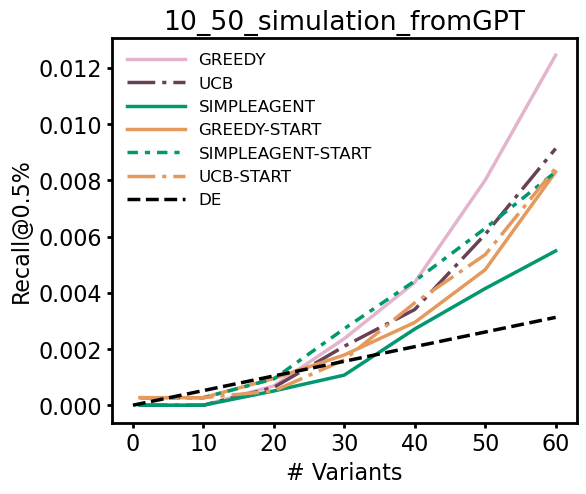

<Figure size 640x480 with 0 Axes>

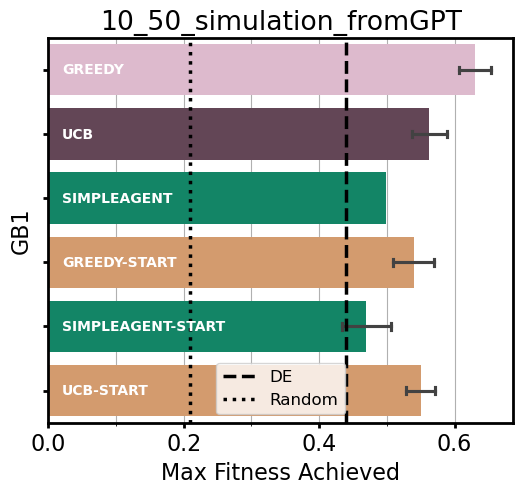

In [67]:
df_start = pd.read_csv('data/10_50_stats_fromGPT.csv')
df_start_agent = pd.read_csv('data/10_50_simpleagent_fromGPT.csv')
df_start['Acquisition'] = df_start['Acquisition'].apply(lambda x: x + '-START')
df_start_agent['Acquisition'] = df_start_agent['Acquisition'].apply(lambda x: x + '-START')
df_start = apply_steps_se(df_start, se=False)
df_start_agent = apply_steps_se(df_start_agent, se=False)
df_agent = dfshort[(dfshort['Acquisition'] == 'SIMPLEAGENT') & (dfshort['Model'] == 'DNN Ensemble')].groupby(['Protein', 'Timestep', 'Acquisition']).mean().reset_index()
both = pd.concat([df_agent, df_start[df_start['Model'] == 'DNN Ensemble'], apply_steps_se(statsdf[statsdf['Model'] == 'DNN Ensemble'], se=False), df_start_agent[df_start_agent['Model'] == 'DNN Ensemble']])

to_plot = ['GREEDY','UCB','SIMPLEAGENT','GREEDY-START','UCB-START','SIMPLEAGENT-START']
plot_single(both[(both['Protein'] == 'GB1') & (both['Acquisition'].isin(to_plot))], 50, 10, '10_50_simulation_fromGPT', 'GB1')